In [43]:
pip install tensorflow_addons

     -------------------------------------- 719.8/719.8 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

In [4]:
def load_data():
    # loading and preprocessing dataset 
    data = pd.read_csv("../dataset/annotations/annotations.csv")
    data = data[['id','image','score']]
        
    images = []
    for i in range(0,len(data)):
        filepath = data['image'][i]
        image = cv2.imread('../dataset/images/{0}'.format(filepath),cv2.IMREAD_COLOR)

        if image is not None:
            new_dimensions = (224, 224)
            resized_image = cv2.resize(image, new_dimensions, interpolation=cv2.INTER_AREA)
            images.append(resized_image)

    return np.array(images), np.array(data['score'])

In [5]:
images, ratings = load_data()
images = images / 255.0  # normalize images

print(images.shape)

X_train, X_test, y_train, y_test = train_test_split(images, ratings, test_size=0.2, random_state=42)

print(y_train)


(1985, 224, 224, 3)
[64. 79. 39. ... 71. 54. 57.]


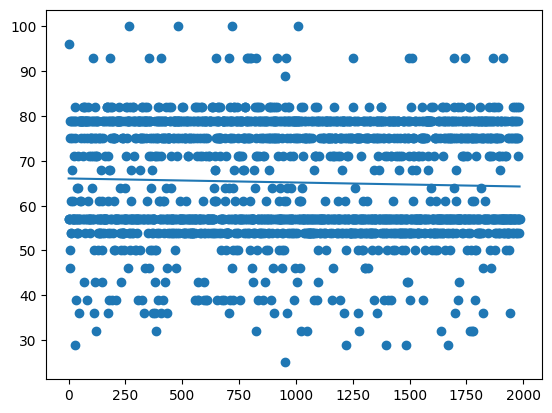

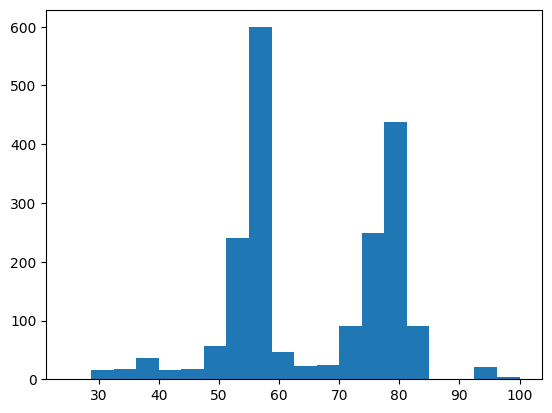

In [63]:
slope, intercept, r, p, std_err = stats.linregress(range(len(ratings)), ratings)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, range(len(ratings))))

plt.scatter(range(len(ratings)), ratings)
plt.plot(range(len(ratings)), mymodel)
plt.show()

plt.hist(ratings,20)
plt.show()


In [52]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224,224,3)
    )

# Add custom top layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)  # Output layer for regression

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae',tf.keras.metrics.R2Score()])
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 1736.1073 - mae: 35.1512 - r2_score: -9.8485 - val_loss: 206.8890 - val_mae: 11.1151 - val_r2_score: -0.2961
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 209.2377 - mae: 12.0162 - r2_score: -0.2875 - val_loss: 169.9457 - val_mae: 11.3187 - val_r2_score: -0.0647
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 179.6148 - mae: 11.6171 - r2_score: -0.1623 - val_loss: 169.3274 - val_mae: 11.5671 - val_r2_score: -0.0608
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 177.5084 - mae: 11.3775 - r2_score: -0.1715 - val_loss: 165.4492 - val_mae: 11.2886 - val_r2_score: -0.0365
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 186.4545 - mae: 11.7199 - r2_score: -0.1421 - val_loss: 165.1753 - val_mae: 11.1903 - val_r2_score: -0.0348
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 176.6305 - mae: 11.5028 - r2_score: -0.1691 - val_loss: 164.3069 - val_mae: 11.1875 - val_r2_score: -0.0293
Epo

In [56]:
test_loss, test_mae, test_r2 = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')
print(f'Test loss: {test_loss}')
print(f'Test r2: {test_r2}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 853ms/step - loss: 164.6719 - mae: 11.3437 - r2_score: 0.0057
Test MAE: 11.449625968933105
Test loss: 163.414794921875
Test r2: 0.002323329448699951


In [64]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mae',tf.keras.metrics.R2Score()])
history_fine = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - loss: 260.4288 - mae: 13.1178 - val_loss: 161.0079 - val_mae: 11.3809
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 166.8807 - mae: 11.1307 - val_loss: 163.2157 - val_mae: 11.4540
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 155.9899 - mae: 10.5964 - val_loss: 166.7509 - val_mae: 11.5572
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 155.1964 - mae: 10.5871 - val_loss: 168.3367 - val_mae: 11.5751
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 145.1451 - mae: 10.0808 - val_loss: 181.0011 - val_mae: 11.8741
Epoch 6/10
19/40 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 142.0835 - mae: 10.0487

KeyboardInterrupt: 

In [ ]:
#model.save("BetterSEOModel.keras")
model.save("BetterSEOModel.h5")

In [ ]:
new_model = tf.keras.models.load_model('BetterSEOModel.h5')

In [ ]:
# Predict rating for a new screenshot
def predict_rating(screenshot):
    new_dimensions = (224,224)
    resized_image = cv2.resize(screenshot, new_dimensions, interpolation=cv2.INTER_AREA)
    screenshot = resized_image / 255.0
    screenshot = np.expand_dims(screenshot, axis=0)  
    predicted_rating = new_model.predict(screenshot)
    return predicted_rating[0][0]

# Load Screenshot and make prediction
new_screenshot = cv2.imread('../dataset/images/{0}'.format('animemojo.png'),cv2.IMREAD_COLOR)
predicted_rating = predict_rating(new_screenshot)
print(f'Predicted Rating: {predicted_rating}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Rating: 72.94987487792969
